<a href="https://colab.research.google.com/github/Dhruvteja/A-Deep-Learning-Approach-for-he-Detection-of-Alzheimer-Disease-/blob/main/95_96DenseNet_169_on_MRI_images__(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DenseNet-169**

###Importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 25.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 33.0 MB/s eta 0:00:00


###Importing Headers

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tqdm import tqdm
import io
import seaborn as sns
import tensorflow_addons as tfa
import ipywidgets as widgets
from PIL import Image

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.io import imread, imshow

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

from keras.layers.pooling.max_pooling2d import MaxPooling2D
from keras.utils.vis_utils import plot_model

from IPython.display import display, clear_output

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data Preprocessing

### Loading train data

In [ ]:
labels = ['MildDemented','ModerateDemented', 'NonDemented', 'VeryMildDemented']

X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=224

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Major_Project/Data', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)

# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)


100%|██████████| 1998/1998 [00:33<00:00, 59.23it/s] 


### Data Description

100%|██████████| 5/5 [00:00<00:00, 415.76it/s]


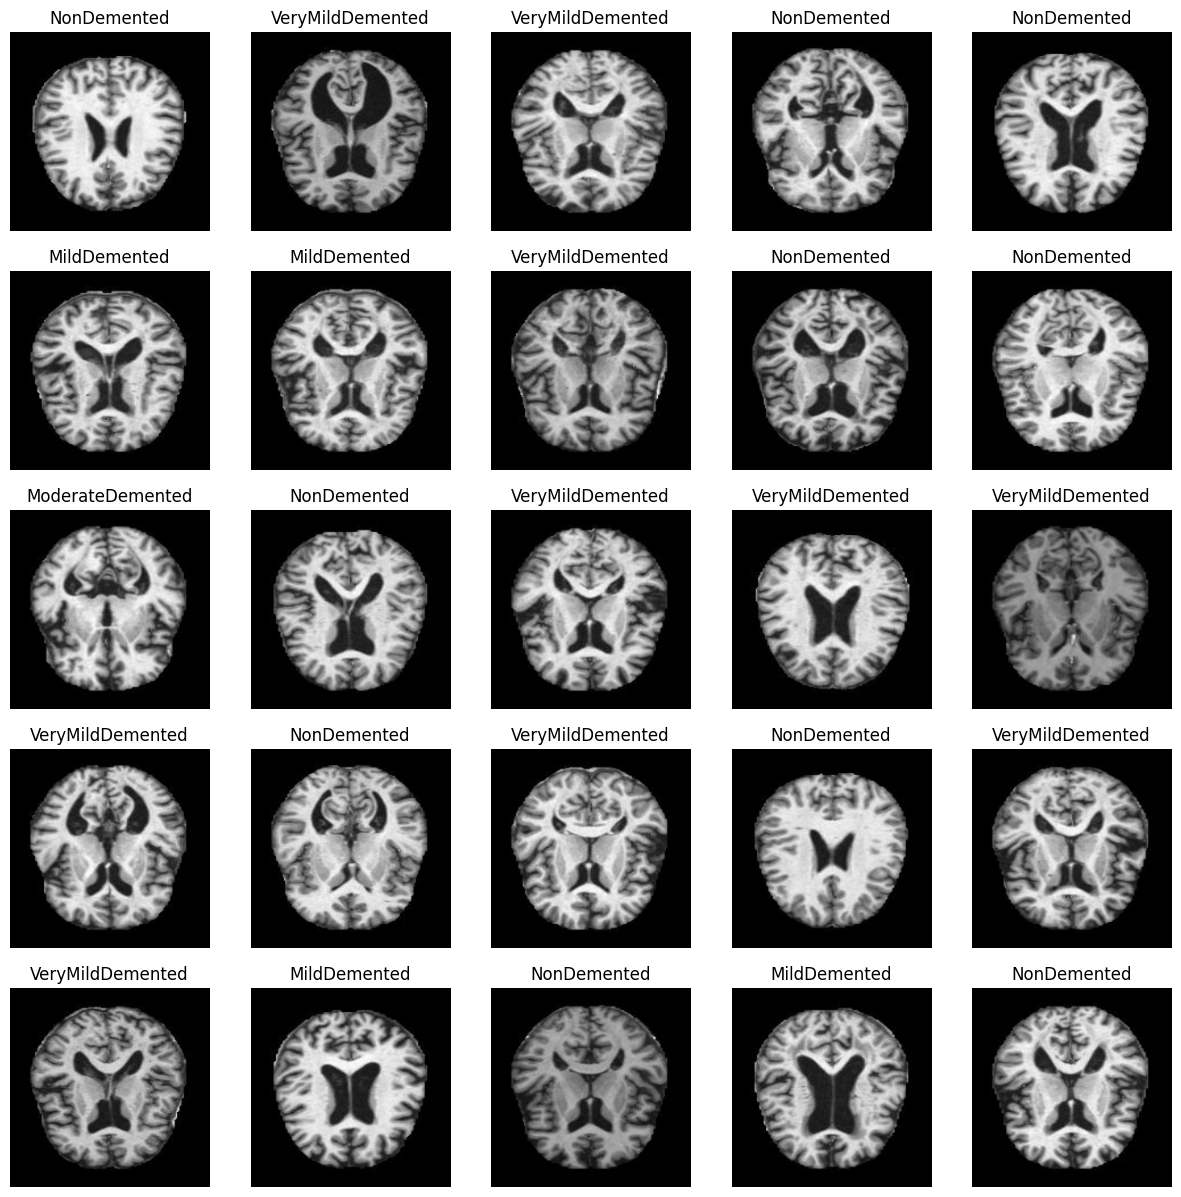

In [ ]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize=(15,15))
for j in range(0,5):
  for i in tqdm(range(0,5)):
      rand1 = np.random.randint(len(X_train))
      ax[j][i].imshow(X_train[rand1])
      ax[j][i].axis('off')
      a = Y_train[rand1]
      ax[j][i].set_title(a)

In [ ]:
#checking shape of training data

print(Xtrain.shape)
print(Ytrain.shape)


(5747, 224, 224, 3)
(5747,)


###Shuffling train and validation data

In [ ]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=44)

#train test split which is divided train dataset and validation dataset

xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.2, random_state=42)



###Converting labels into encoder

In [ ]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e

ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

## Model Building

###Building DenseNet169 Model

In [ ]:
model_d = DenseNet169(weights='imagenet',include_top=False, input_shape=(image_size, image_size, 3))

51877672/51877672 [==============================] - 2s 0us/step


In [ ]:
#Freezing Layers

for layer in model_d.layers:
    layer.trainable=False

In [ ]:
model=Sequential()
model.add(model_d)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 2048)              0

###Metrics for evaluating model

In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tfa.metrics.F1Score(num_classes = 4, name='f1_score')
]

###Compiling Model

In [ ]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

###Defining Callbacks

In [ ]:
filepath = '/content/drive/MyDrive/weight/best_weights_MRI.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor='accuracy',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                            min_delta=0.001)

callback_list = [earlystopping, checkpoint, reduce_lr]

##Training Model

In [ ]:
history = model.fit(xtrain,
                    ytrain,
                    batch_size=32,
                    validation_split=0.1,
                    epochs=100,
                    verbose=1,
                    callbacks=[earlystopping, checkpoint, reduce_lr])

Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 1.0397 - accuracy: 0.6299 - precision: 0.6570 - recall: 0.5898 - auc: 0.8566 - f1_score: 0.5982
Epoch 1: val_auc improved from -inf to 0.91945, saving model to /content/drive/MyDrive/weight/best_weights_MRI.hdf5
130/130 [==============================] - 116s 714ms/step - loss: 1.0397 - accuracy: 0.6299 - precision: 0.6570 - recall: 0.5898 - auc: 0.8566 - f1_score: 0.5982 - val_loss: 0.7127 - val_accuracy: 0.7283 - val_precision: 0.7602 - val_recall: 0.6891 - val_auc: 0.9194 - val_f1_score: 0.7362 - lr: 0.0010
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7933 - precision: 0.8120 - recall: 0.7713 - auc: 0.9483 - f1_score: 0.7701
Epoch 2: val_auc improved from 0.91945 to 0.95373, saving model to /content/drive/MyDrive/weight/best_weights_MRI.hdf5
130/130 [==============================] - 38s 294ms/step - loss: 0.5493 - accuracy: 0.7933 - precision: 0.8120 - recall: 0.771

##Model Evaluation


###Loss and Accuracy plots

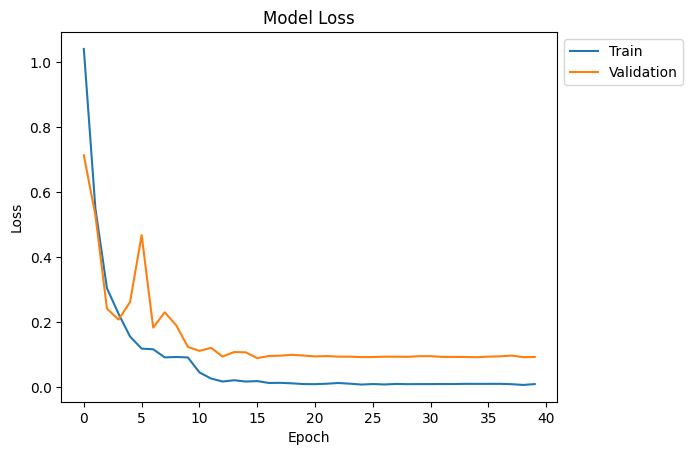

<Figure size 640x480 with 0 Axes>

In [ ]:
# Summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()
plt.savefig('/content/drive/MyDrive/Major_Project/output images/' + 'model_loss.png', dpi=300) # Save plot as PNG


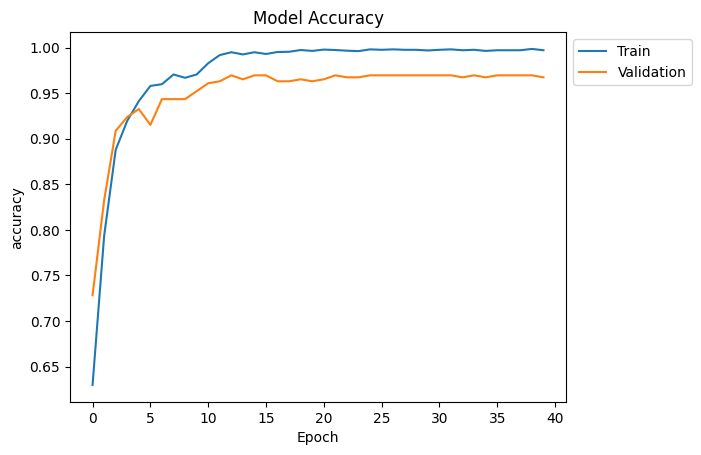

<Figure size 640x480 with 0 Axes>

In [ ]:
# Summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()
plt.savefig('/content/drive/MyDrive/Major_Project/output images/' + 'model_accuracy.png', dpi=300) # Save plot as PNG


####Train data evaluation

In [ ]:
#Train data prediction
true_train_classes = np.argmax(ytrain,axis=1)

ypred = model.predict(xtrain)

pred_train_classes = np.argmax(ypred, axis=1)

acc = accuracy_score(true_train_classes,pred_train_classes)
print("Model Train Accuracy: {:.2f}%".format(acc * 100))
print(classification_report(true_train_classes,pred_train_classes))

144/144 [==============================] - 22s 126ms/step
Model Train Accuracy: 99.67%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       530
           1       0.99      1.00      1.00       362
           2       1.00      1.00      1.00      2105
           3       1.00      1.00      1.00      1600

    accuracy                           1.00      4597
   macro avg       1.00      1.00      1.00      4597
weighted avg       1.00      1.00      1.00      4597



In [ ]:
model.evaluate(xtrain,ytrain)

144/144 [==============================] - 16s 114ms/step - loss: 0.0094 - accuracy: 0.9967 - precision: 0.9970 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9966


[0.009367011487483978,
 0.996737003326416,
 0.9969531893730164,
 0.9965194463729858,
 0.9998450875282288,
 array([0.9971671 , 0.99586207, 0.99738526, 0.99594134], dtype=float32)]

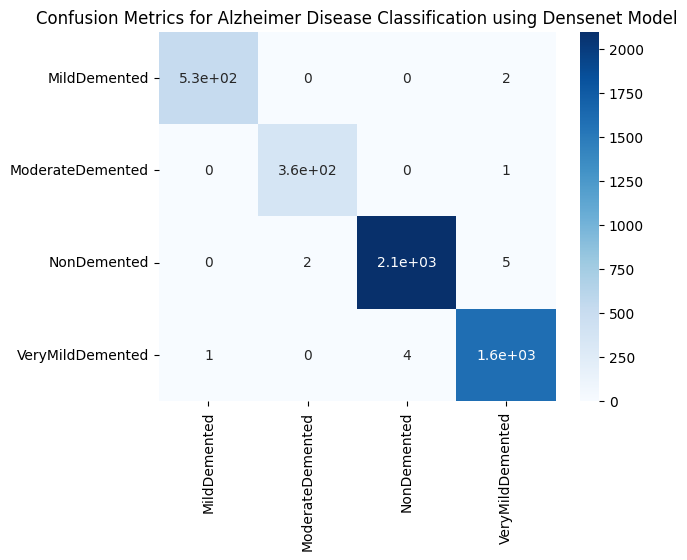

In [ ]:
Cm=confusion_matrix(true_train_classes,pred_train_classes)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Densenet Model")
plt.savefig('/content/drive/MyDrive/Major_Project/output images/' + 'densenet_train_confusion.png', dpi=300) # Save plot as PNG
plt.show()

####Validation data evaluation

In [ ]:
#Validation data prediction
true_valid_classes = np.argmax(ytest,axis=1)

ypred = model.predict(xtest)

pred_valid_classes = np.argmax(ypred, axis=1)

acc = accuracy_score(true_valid_classes, pred_valid_classes)
print("Model Validation Accuracy: {:.2f}%".format(acc * 100))
print(classification_report(true_valid_classes, pred_valid_classes))

36/36 [==============================] - 7s 190ms/step
Model Validation Accuracy: 98.35%
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       140
           1       0.98      0.98      0.98        92
           2       0.98      0.98      0.98       520
           3       0.98      0.98      0.98       398

    accuracy                           0.98      1150
   macro avg       0.98      0.98      0.98      1150
weighted avg       0.98      0.98      0.98      1150



In [ ]:
model.evaluate(xtest,ytest)

36/36 [==============================] - 4s 113ms/step - loss: 0.0718 - accuracy: 0.9835 - precision: 0.9843 - recall: 0.9835 - auc: 0.9968 - f1_score: 0.9827


[0.07179322093725204,
 0.9834782481193542,
 0.9843342304229736,
 0.9834782481193542,
 0.9967755079269409,
 array([0.9856115 , 0.9782609 , 0.9846154 , 0.98245615], dtype=float32)]

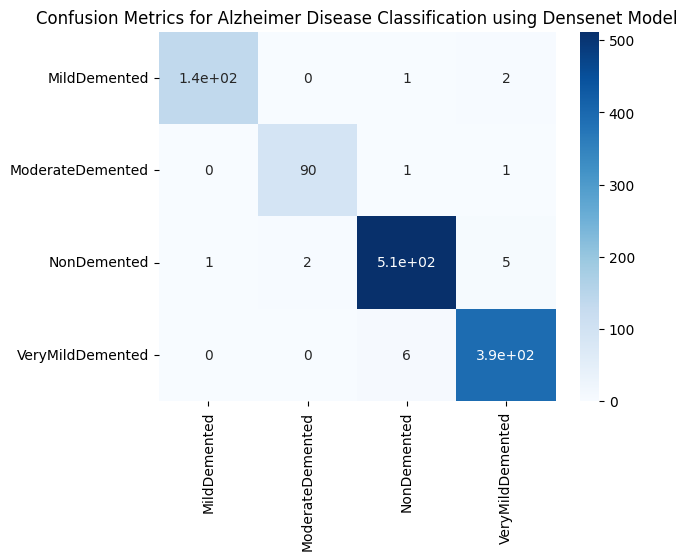

In [ ]:
Cm=confusion_matrix(true_valid_classes, pred_valid_classes)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Densenet Model")
plt.savefig('/content/drive/MyDrive/Major_Project/output images/' + 'densenet_validation_confusion.png', dpi=300) # Save plot as PNG
plt.show()

####Loading Test data

In [ ]:
labels = ['MildDemented','ModerateDemented', 'NonDemented', 'VeryMildDemented']

test_data = [] #Training Dataset
test_label = [] #Training Labels

image_size=224

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Major_Project/Data', 'test', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        test_data.append(image)
        test_label.append(i)

# converted into array

test_d = np.array(test_data)
test_l = np.array(test_label)

new_test_l =[]
for i in test_l:
    new_test_l.append(labels.index(i))

y_ttest = to_categorical(new_test_l)

100%|██████████| 448/448 [00:04<00:00, 90.34it/s] 


####Test data Evaluation


In [ ]:
#Test data prediction
true_classes = np.argmax(y_ttest,axis=1)
print(true_classes)
ypred = model.predict(test_d)
ypred
pred_classes = np.argmax(ypred, axis=1)
print(pred_classes)
acc = accuracy_score(true_classes, pred_classes)
print("Model Test Accuracy: {:.2f}%".format(acc * 100))
print(classification_report(true_classes,pred_classes,target_names = labels))

[0 0 0 ... 3 3 3]
41/41 [==============================] - 6s 156ms/step
[0 0 0 ... 3 3 3]
Model Test Accuracy: 96.44%
                  precision    recall  f1-score   support

    MildDemented       0.99      0.96      0.97       179
ModerateDemented       1.00      0.83      0.91        24
     NonDemented       1.00      0.95      0.97       640
VeryMildDemented       0.91      1.00      0.95       448

        accuracy                           0.96      1291
       macro avg       0.97      0.93      0.95      1291
    weighted avg       0.97      0.96      0.96      1291



In [ ]:
model.evaluate(test_d,y_ttest)

41/41 [==============================] - 5s 112ms/step - loss: 0.0915 - accuracy: 0.9644 - precision: 0.9651 - recall: 0.9636 - auc: 0.9978 - f1_score: 0.9516


[0.0914718508720398,
 0.9643687009811401,
 0.9650892019271851,
 0.9635941386222839,
 0.9978112578392029,
 array([0.9715909 , 0.90909094, 0.9727564 , 0.9530917 ], dtype=float32)]

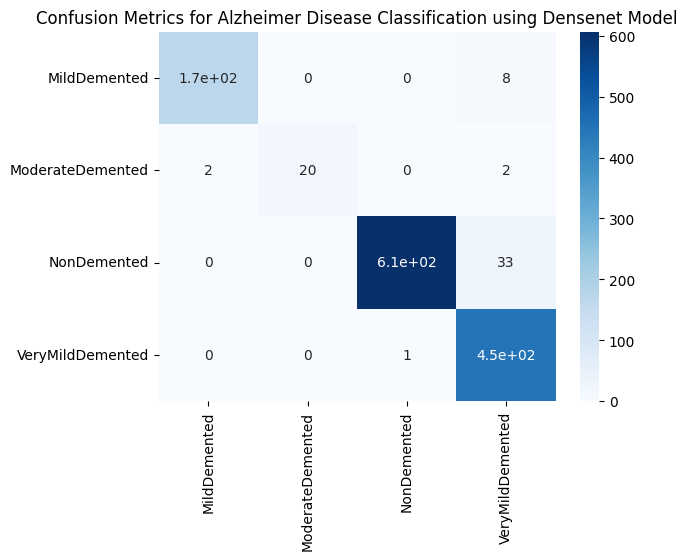

In [ ]:
Cm=confusion_matrix(true_classes,pred_classes)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Densenet Model")
plt.savefig('/content/drive/MyDrive/Major_Project/output images/' + 'densenet_test_confusion.png', dpi=300) # Save plot as PNG
plt.show()


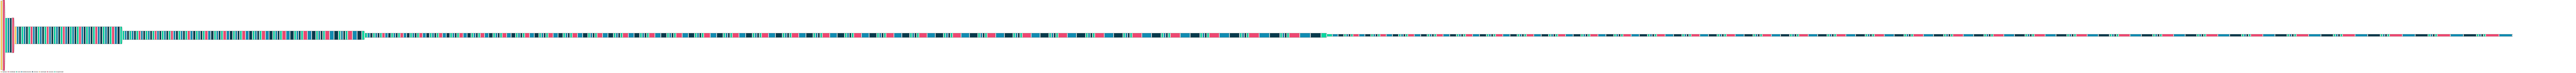

In [ ]:
import visualkeras
visualkeras.layered_view(model_d, to_file='/content/drive/MyDrive/Major_Project/output images/' + 'output.png',legend=True, draw_volume=False)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.497911 to fit



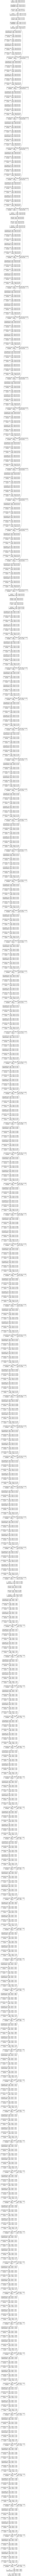

In [ ]:
from keras.utils.vis_utils import plot_model
#pretrained_model = tf.keras.models.load_model(model_dir)
plot_model(model_d, to_file="/content/drive/MyDrive/Major_Project/output images/" + "model_plot.png", show_shapes=True, show_layer_names=True)

###Testing Model on Random Data

In [ ]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))

    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(224, 224))
    images = images.reshape(1, 224, 224, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]


    if prd == 0:
        prd = "MildDemented"
    elif prd == 1:
        prd = "ModerateDemented"
    elif prd ==2:
        prd = "NonDemented"
    elif prd ==3:
        prd = "VeryMildDemented"


    probability = round(np.max(model.predict(images)*100),2)
    print(probability, '% chances are there that the image is',prd)

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")


button.on_click(on_button_click)
widgets.VBox([button, out])